# Results for GDF+PCA+GRU for 30 runs

Here we present results for the best GRUs choosen based on best MCC (matthews) score on validation set. 
The features for GRUs are GDFs reduced by PCA (number of components is chosen based on sum of explained variance ratio > 0.99).

Because GRUs are not deterministic, the scores may vary, so we calculated scores 30 times for each model. Next we took mean obtained scores, so we can compare with scores obtained for Logistic Regression on Queue Imbalance feature (QUE+LOG).

In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import GRU


from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.layers import GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_dir = 'res_gdf_pca_gru_iter/'
data_dir_que_log = '../queue_imbalance/res_que_log'
if_should_savefig = False

In [3]:
df_log = pd.DataFrame()
for f in os.listdir(data_dir_que_log):
    if 'csv' not in f:
        continue
    d = pd.read_csv(os.path.join(data_dir_que_log, f))
    df_log = df_log.append(d)

## Data 

Columns with suffix `gru` are scores obtained using GDF+PCA+GRU.

Columns with suffix `log` are scores obtained using QUE+LOG.

Columns with *prefix* `diff` are differences of scores between GRUs - LOGs.

`r`, `s` - parameters for GDF (s - sigma, r - scale).

In [4]:
df_res = pd.DataFrame()
for f in os.listdir(data_dir):
    if 'csv' not in f:
        continue
    d = pd.read_csv(os.path.join(data_dir, f))
    df_res = df_res.append(d)  

columns = ['matthews', 'test_matthews', 'stock', 'unit']
df_best = df_res.sort_values(by='matthews', ascending=False).groupby(['stock']).mean()
df_best = pd.merge(df_best, df_log, on='stock', suffixes=['_gru', '_log'])
df_best.index = df_best['stock']

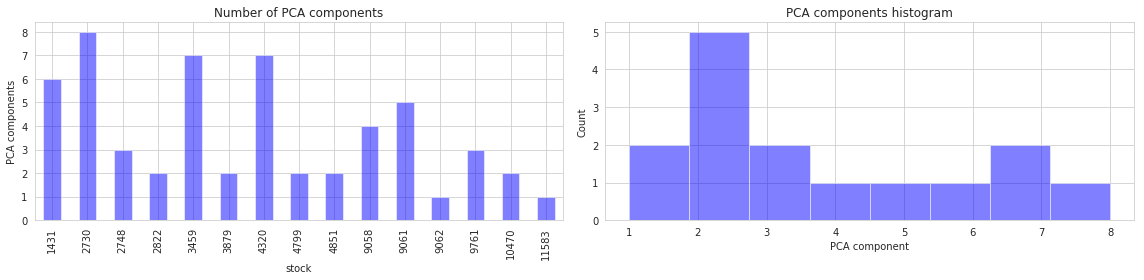

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_best['pca_components'].plot(kind='bar', color=['b'], alpha=0.5, ax=ax1)
ax1.set_title('Number of PCA components')
ax1.set_ylabel('PCA components')

df_best['pca_components'].hist(color='b', alpha=0.5, bins=8)
ax2.set_title('PCA components histogram')
ax2.set_ylabel('Count')
ax2.set_xlabel('PCA component')


plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_gru_pca_components.png')

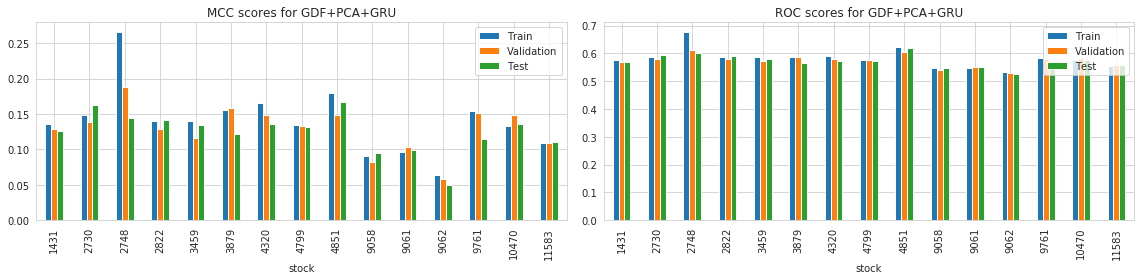

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

df_best[['train_matthews_gru', 'matthews_gru', 'test_matthews_gru']].plot(kind='bar', ax=ax1)
ax1.legend(['Train', 'Validation', 'Test'])

ax1.set_title('MCC scores for GDF+PCA+GRU')

df_best[['train_roc_auc_gru', 'roc_auc_gru', 'test_roc_auc_gru']].plot(kind='bar', ax=ax2)
ax2.legend(['Train', 'Validation', 'Test'])

ax2.set_title('ROC scores for GDF+PCA+GRU')
plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_gru_mcc_roc_bar.png')

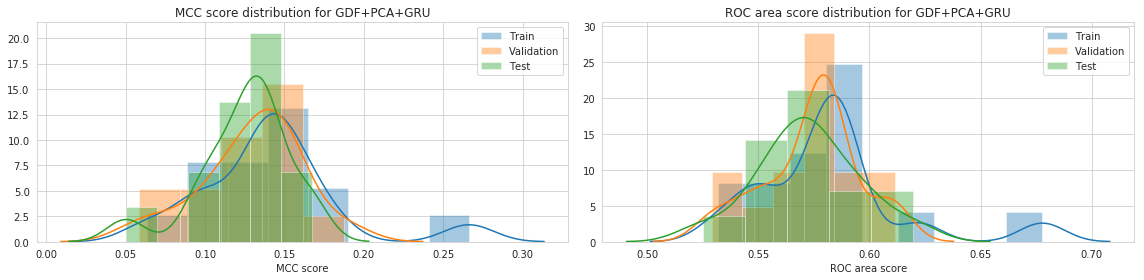

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.distplot(df_best['train_matthews_gru'], label='Train', ax=ax1)
sns.distplot(df_best['matthews_gru'], label='Validation', ax=ax1)
sns.distplot(df_best['test_matthews_gru'], label='Test', ax=ax1)
ax1.legend(['Train', 'Validation', 'Test'])
ax1.set_title('MCC score distribution for GDF+PCA+GRU')
ax1.set_xlabel('MCC score')

sns.distplot(df_best['train_roc_auc_gru'], label='Train', ax=ax2)
sns.distplot(df_best['roc_auc_gru'], label='Validation', ax=ax2)
sns.distplot(df_best['test_roc_auc_gru'], label='Test', ax=ax2)
ax2.legend(['Train', 'Validation', 'Test'])
ax2.set_title('ROC area score distribution for GDF+PCA+GRU')
ax2.set_xlabel('ROC area score')

plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_gru_score_dist.png')

In [8]:
df_best[['train_matthews_gru', 'matthews_gru', 'test_matthews_gru', 
        'train_roc_auc_gru', 'roc_auc_gru', 'test_roc_auc_gru']].describe()

,train_matthews_gru,matthews_gru,test_matthews_gru,train_roc_auc_gru,roc_auc_gru,test_roc_auc_gru
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.140834,0.129516,0.124911,0.582206,0.574047,0.572531
std,0.046199,0.032159,0.028992,0.034428,0.022109,0.023380
min,0.063412,0.058509,0.050159,0.531857,0.529132,0.525227
25%,0.120656,0.112841,0.112725,0.565715,0.563576,0.560017
50%,0.139917,0.133453,0.131989,0.584202,0.580344,0.573492
75%,0.155196,0.148953,0.139109,0.587919,0.582752,0.585171
max,0.266273,0.187762,0.167083,0.677755,0.611680,0.619784


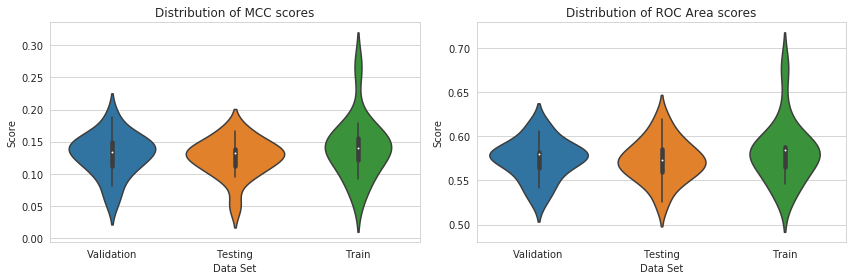

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

columns = ['stock', 'matthews_gru', 'roc_auc_gru', 
           'test_matthews_gru', 'test_roc_auc_gru', 'train_matthews_gru', 'train_roc_auc_gru']

df = df_best[columns].copy()
df.rename(columns={
    'matthews_gru': 'Validation', 'test_matthews_gru': 'Testing', 'train_matthews_gru': 'Train'}, inplace=True)
df = df.melt(['stock', 'roc_auc_gru', 'test_roc_auc_gru', 'train_roc_auc_gru'])
sns.violinplot(x="variable", y="value", data=df, ax=ax1)
ax1.set_title('Distribution of MCC scores')

ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_best[columns].copy()
df.rename(columns={'roc_auc_gru': 'Validation', 'test_roc_auc_gru': 'Testing', 'train_roc_auc_gru': 'Train'}, inplace=True)
df = df.melt(['stock', 'matthews_gru', 'test_matthews_gru', 'train_matthews_gru'])

ax2.set_title('Distribution of ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')

plt.tight_layout()
if if_should_savefig:
    plt.savefig('violin_distribution_scores_gdf_pca_gru.png')

Text(0.5,1,'Number of timesteps for GRU')

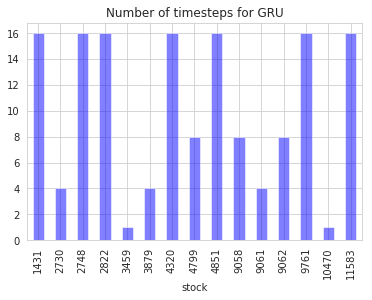

In [10]:
df_best['n_steps'].plot(kind='bar', color=['b'], alpha=0.5)
plt.title('Number of timesteps for GRU')

## Comparision with QUE+LOG

In [11]:
df_best['diff_test_matthews'] = df_best['test_matthews_gru'] - df_best['test_matthews_log']
df_best['diff_train_matthews'] = df_best['train_matthews_gru'] - df_best['train_matthews_log']
df_best['diff_matthews'] = df_best['matthews_gru'] - df_best['matthews_log']
df_best['diff_test_roc_auc'] = df_best['test_roc_auc_gru'] - df_best['test_roc_auc_log']
df_best['diff_train_roc_auc'] = df_best['train_roc_auc_gru'] - df_best['train_roc_auc_log']
df_best['diff_roc_auc'] = df_best['roc_auc_gru'] - df_best['roc_auc_log']

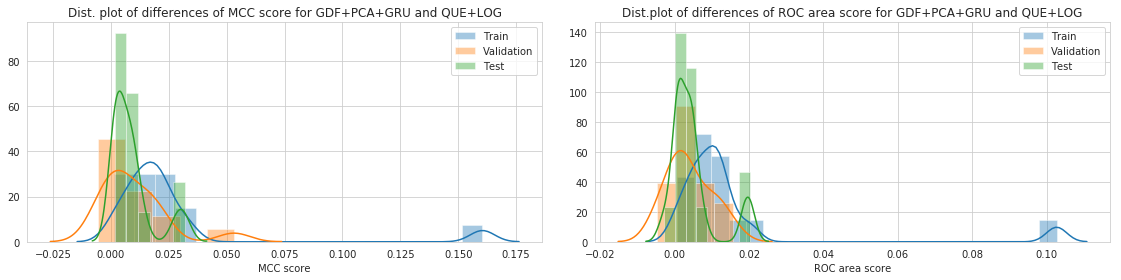

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.distplot(df_best['diff_train_matthews'], label='Train', ax=ax1)
sns.distplot(df_best['diff_matthews'], label='Validation', ax=ax1)
sns.distplot(df_best['diff_test_matthews'], label='Test', ax=ax1)
ax1.set_title('Dist. plot of differences of MCC score for GDF+PCA+GRU and QUE+LOG')
ax1.set_xlabel('MCC score')
ax1.legend()

sns.distplot(df_best['diff_train_roc_auc'], label='Train', ax=ax2)
sns.distplot(df_best['diff_roc_auc'], label='Validation', ax=ax2)
sns.distplot(df_best['diff_test_roc_auc'], label='Test', ax=ax2)
ax2.set_title('Dist.plot of differences of ROC area score for GDF+PCA+GRU and QUE+LOG')
ax2.set_xlabel('ROC area score')
ax2.legend()
plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_gru_and_que_log_score_diff.png')

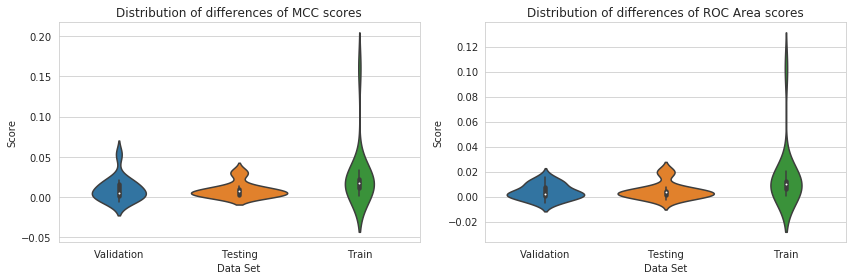

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

columns = ['stock', 'diff_matthews', 'diff_roc_auc', 
           'diff_test_matthews', 'diff_test_roc_auc', 'diff_train_matthews', 'diff_train_roc_auc']

df = df_best[columns].copy()
df.rename(columns={
    'diff_matthews': 'Validation', 'diff_test_matthews': 'Testing', 'diff_train_matthews': 'Train'}, inplace=True)
df = df.melt(['stock', 'diff_roc_auc', 'diff_test_roc_auc', 'diff_train_roc_auc'])
sns.violinplot(x="variable", y="value", data=df, ax=ax1)
ax1.set_title('Distribution of differences of MCC scores')

ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_best[columns].copy()
df.rename(
    columns={'diff_roc_auc': 'Validation', 'diff_test_roc_auc': 'Testing', 'diff_train_roc_auc': 'Train'}, 
    inplace=True)
df = df.melt(['stock', 'diff_matthews', 'diff_test_matthews', 'diff_train_matthews'])

ax2.set_title('Distribution of differences of ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')

plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_gru_and_que_log_violin_score_diff.png')

The table below shows the values for the differences, which distributions are on a plot above.

In [14]:
df_best[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
        'diff_train_roc_auc', 'diff_roc_auc', 'diff_test_roc_auc']].describe()

,diff_train_matthews,diff_matthews,diff_test_matthews,diff_train_roc_auc,diff_roc_auc,diff_test_roc_auc
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.026027,0.009906,0.008933,0.015442,0.003980,0.004816
std,0.038206,0.014783,0.009351,0.024672,0.006006,0.006508
min,0.001224,-0.005566,0.001577,0.000604,-0.004772,-0.002731
25%,0.011184,0.001310,0.002513,0.006301,0.000522,0.001085
50%,0.018035,0.004523,0.007665,0.009873,0.001748,0.004133
75%,0.022718,0.016355,0.009546,0.012231,0.008120,0.004742
max,0.160435,0.053144,0.031839,0.102670,0.015797,0.020248


In [15]:
print('stocks having worse roc area score for GRU vs LOG on test set')
print(df_best[df_best['test_roc_auc_gru'] < df_best['test_roc_auc_log']]['stock'].values)
df_best[df_best['test_roc_auc_gru'] < df_best['test_roc_auc_log']][[
    'roc_auc_gru', 'roc_auc_log', 'test_roc_auc_gru', 'test_roc_auc_log', 'r', 's']]

stocks having worse roc area score for GRU vs LOG on test set
[3459]


,roc_auc_gru,roc_auc_log,test_roc_auc_gru,test_roc_auc_log,r,s
stock,,,,,,
3459,0.572673,0.577445,0.579091,0.581821,0.1,0.1


In [16]:
print('stocks having worse MCC score for GRU vs LOG on test set')
df_best[df_best['test_matthews_gru'] < df_best['test_matthews_log']][[
    'matthews_gru', 'matthews_log', 'test_matthews_gru', 'test_matthews_log', 'r', 's']]

stocks having worse MCC score for GRU vs LOG on test set


,matthews_gru,matthews_log,test_matthews_gru,test_matthews_log,r,s
stock,,,,,,


In [17]:
df_best[['train_matthews_gru', 'train_matthews_log',
    'matthews_gru', 'matthews_log', 'test_matthews_gru', 'test_matthews_log', 'r', 's']]

,train_matthews_gru,train_matthews_log,matthews_gru,matthews_log,test_matthews_gru,test_matthews_log,r,s
stock,,,,,,,,
1431,0.135360,0.117325,0.129154,0.134712,0.125955,0.123369,0.25,0.25
2730,0.148489,0.132427,0.138500,0.136898,0.163374,0.150063,0.25,0.25
2748,0.266273,0.105838,0.187762,0.134618,0.144817,0.134365,0.01,0.10
2822,0.140367,0.120714,0.128481,0.111058,0.142273,0.110434,0.01,0.10
3459,0.139917,0.129942,0.116439,0.122005,0.133871,0.131207,0.10,0.10
3879,0.156212,0.136130,0.158042,0.136745,0.122292,0.120715,0.01,0.10
4320,0.165328,0.142331,0.148878,0.129040,0.135928,0.133488,0.10,0.10
4799,0.134129,0.111690,0.133453,0.130257,0.131989,0.124104,0.25,0.25
4851,0.179479,0.146106,0.149028,0.148009,0.167083,0.138621,0.01,0.10


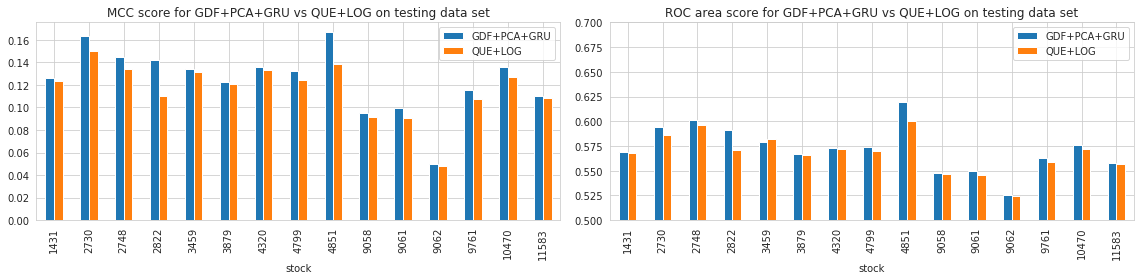

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_best[['test_matthews_gru', 'test_matthews_log']].plot(kind='bar', ax=ax1)
ax1.legend(['GDF+PCA+GRU', 'QUE+LOG'])
ax1.set_title('MCC score for GDF+PCA+GRU vs QUE+LOG on testing data set')

df_best[['test_roc_auc_gru', 'test_roc_auc_log']].plot(kind='bar', ax=ax2)
ax2.legend(['GDF+PCA+GRU', 'QUE+LOG'])
ax2.set_ylim(0.5, 0.7)
ax2.set_title('ROC area score for GDF+PCA+GRU vs QUE+LOG on testing data set')
plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_gru_que_log_mcc_roc_scores_bar.png')

## Conclusions

GDF+PCA+GRU is better from QUE+LOG.